In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load & Inspect Data

file_path = "cars24_20221210.csv"
df = pd.read_csv(file_path)

print(df.head())
print(df.shape)
print(df.dtypes)
print(df.isnull().sum())
print(df.duplicated().sum())
print(df.describe())

                name     make      model       city  year      fueltype  \
0  Hyundai Elite i20  Hyundai  Elite I20      Kochi  2017        Petrol   
1    Maruti Alto 800   Maruti   Alto 800     Mumbai  2016  Petrol + Cng   
2       Maruti Dzire   Maruti      Dzire    Lucknow  2019  Petrol + Cng   
3         KIA SELTOS      Kia     Seltos  Bangalore  2020        Diesel   
4      Maruti Ertiga   Maruti     Ertiga    Kolkata  2017        Petrol   

   kilometerdriven  ownernumber transmission   bodytype  \
0            35939            2       Manual  Hatchback   
1             6180            1       Manual  Hatchback   
2            46808            1       Manual      Sedan   
3            26045            1       Manual        SUV   
4            53056            1       Manual        SUV   

                     storename  isc24assured registrationcity  \
0                    Kochi-Pns         False        Kozhikode   
1               Hi-West Mumbai         False           Mumbai   

In [ ]:
# Data Cleaning

df = df.dropna(subset=['transmission', 'bodytype'])
df = df.drop_duplicates()

# Fix negative discount price
df['discountprice'] = df['discountprice'].abs()

# Add age feature
current_year = datetime.now().year
if "year" in df.columns:
    df["age"] = current_year - pd.to_numeric(df["year"], errors="coerce")

# Map ownernumber → owner_category
owner_map = {1: 'First Owner', 2: 'Second Owner', 3: 'Third Owner'}
df['owner_category'] = df['ownernumber'].map(owner_map)

# Convert isc24assured to int
df['isc24assured'] = df['isc24assured'].astype(int)

# Drop unnecessary columns
df = df.drop(['name', 'storename', 'registrationcity',
              'benefits', 'discountprice', 'url', 'createdDate'], axis=1)


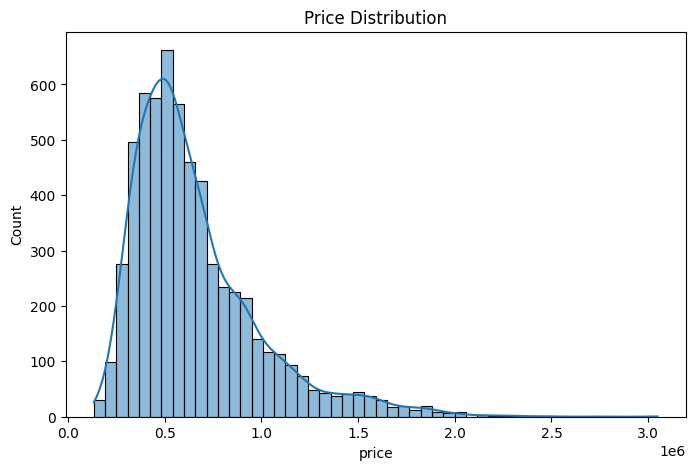

In [ ]:
# Exploratory Data Analysis

plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.show()

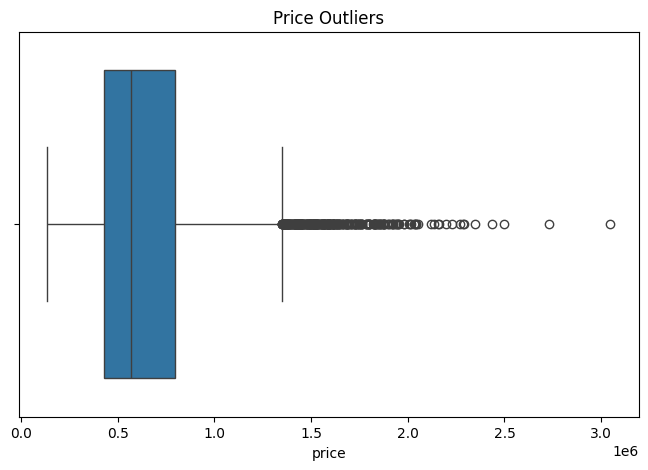

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df['price'])
plt.title("Price Outliers")
plt.show()

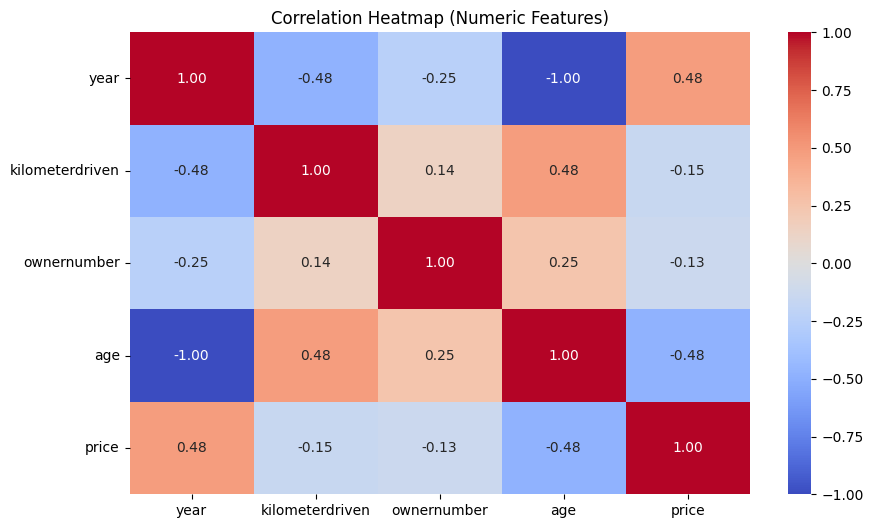

In [ ]:
numeric_cols = ['year', 'kilometerdriven', 'ownernumber', 'age']
plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_cols + ['price']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

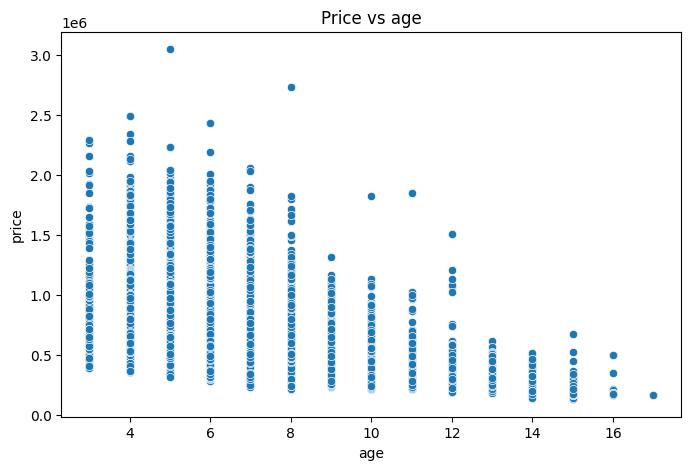

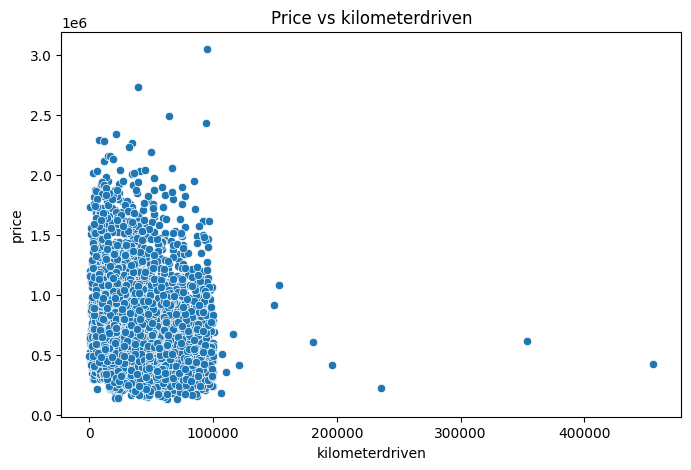

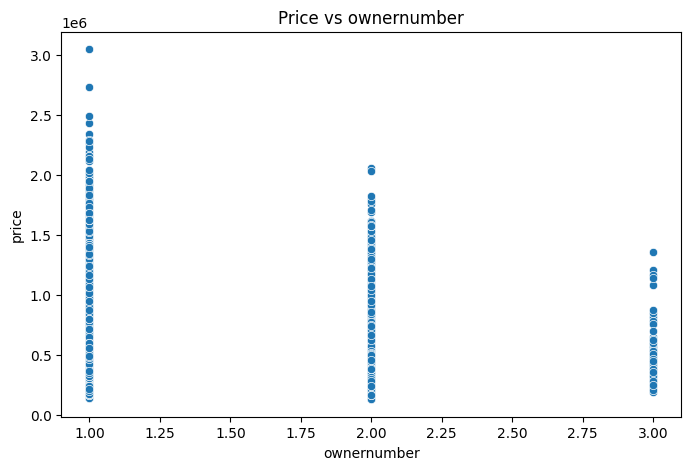

In [ ]:
for col in ['age', 'kilometerdriven', 'ownernumber']:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=df[col], y=df['price'])
    plt.title(f"Price vs {col}")
    plt.show()

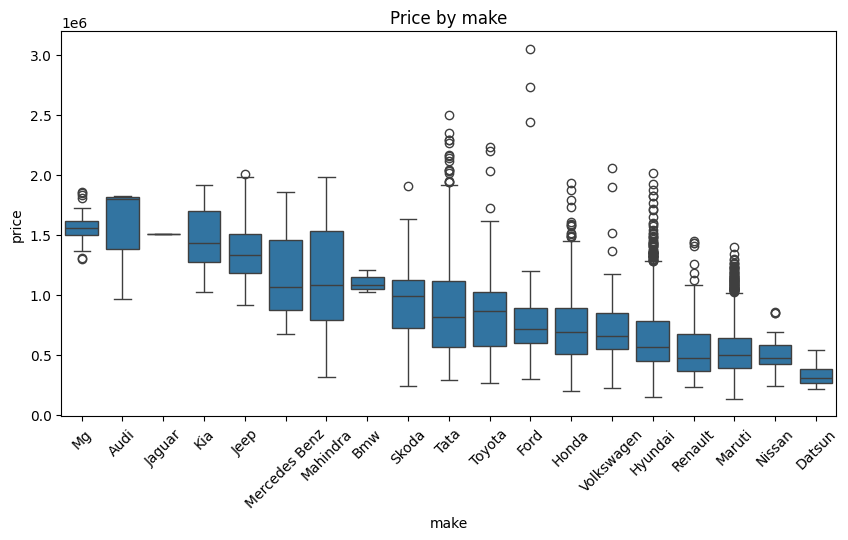

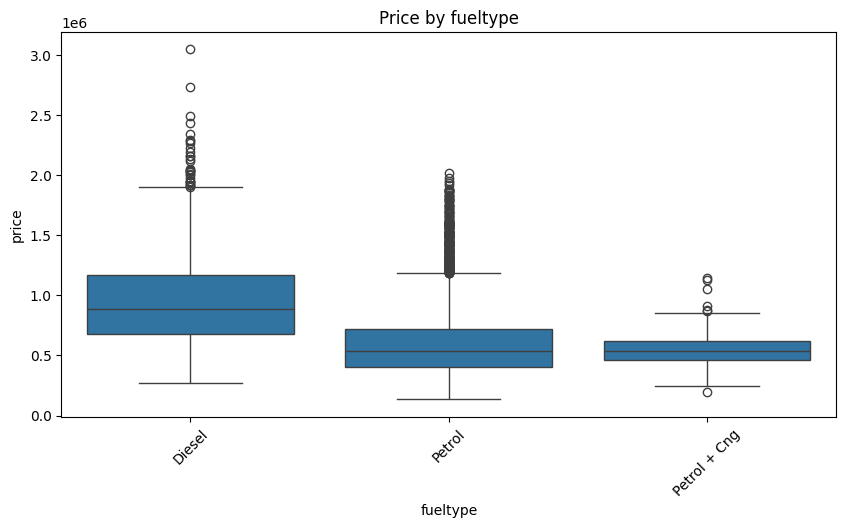

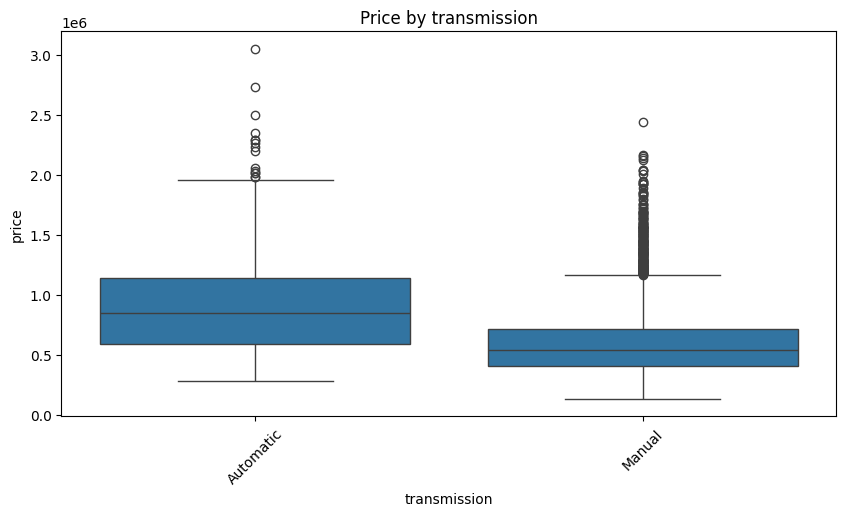

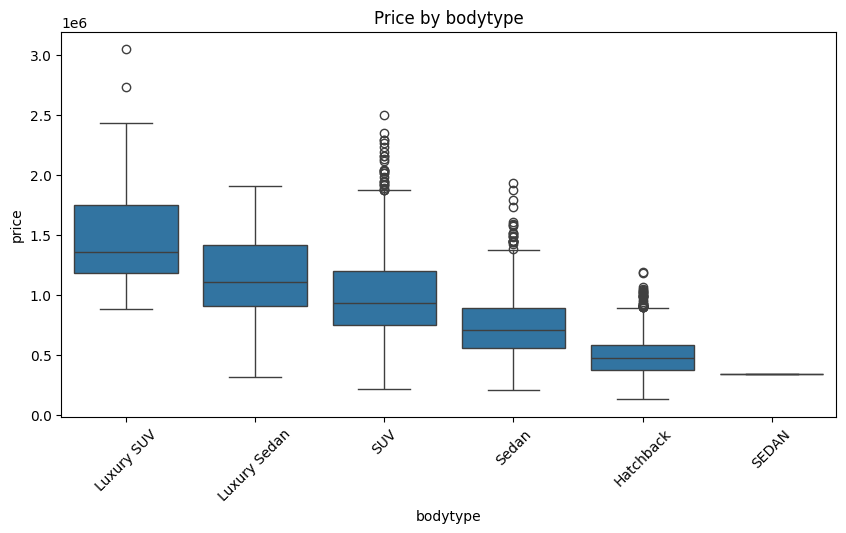

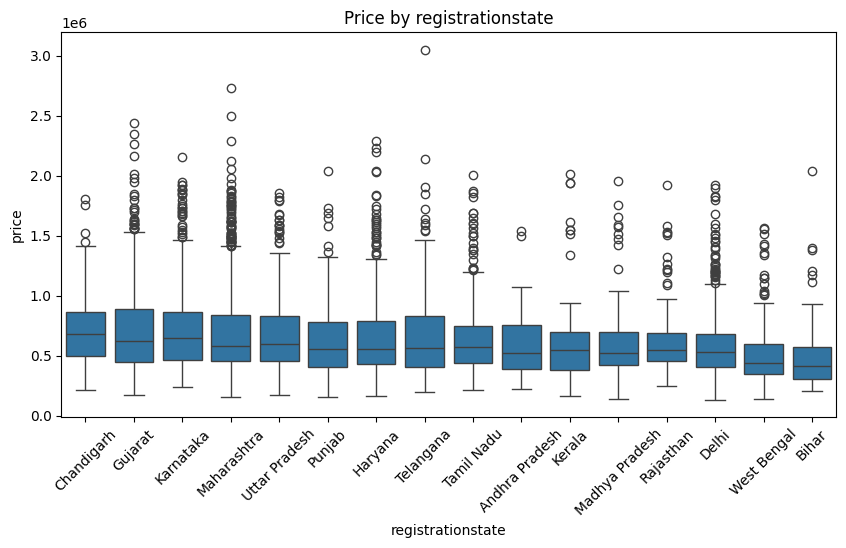

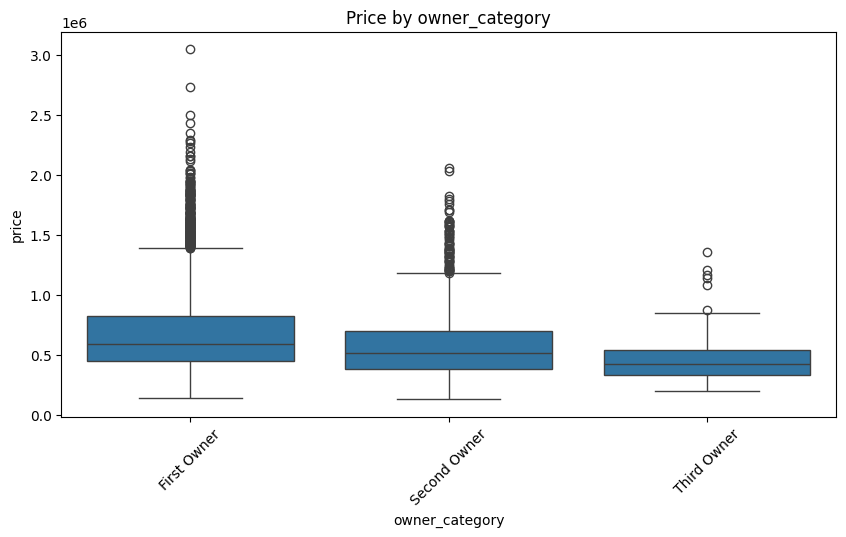

In [ ]:
categorical_cols = ['make', 'fueltype', 'transmission', 'bodytype', 'registrationstate', 'owner_category']
for col in categorical_cols:
    plt.figure(figsize=(10,5))
    order = df.groupby(col)['price'].mean().sort_values(ascending=False).index
    sns.boxplot(x=col, y="price", data=df, order=order)
    plt.xticks(rotation=45)
    plt.title(f"Price by {col}")
    plt.show()

In [ ]:
# Train-Test Split

from sklearn.model_selection import train_test_split

X = df.drop(["price", "ownernumber"], axis=1)  # keep features only
y = df["price"]  # target in rupees (not scaled!)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Preprocessing & Pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define features
numeric_features = ["year", "kilometerdriven", "age"]
categorical_features = ["make", "model", "city", "fueltype", "transmission",
                        "bodytype", "isc24assured", "registrationstate", "owner_category"]

# Preprocessor: scale numeric + one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


In [ ]:
# Pipeline with XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42))
])

# Train model
xgb_pipeline.fit(X_train, y_train)

# Evaluate
y_pred = xgb_pipeline.predict(X_test)
print("XGBoost Performance:")
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²  :", r2_score(y_test, y_pred))


XGBoost Performance:
MAE : 55540.18359375
RMSE: 88866.24988149326
R²  : 0.9299207925796509


In [ ]:
# Save Model
import joblib
joblib.dump(xgb_pipeline, "car_price_xgb.pkl")

['car_price_xgb.pkl']

In [ ]:
# Predict New Car Price

new_car = pd.DataFrame([{
    "make": "Hyundai",
    "model": "i20",
    "city": "Kochi",
    "year": 2016,
    "fueltype": "Petrol",
    "kilometerdriven": 35000,
    "transmission": "Manual",
    "bodytype": "Hatchback",
    "isc24assured": 1,
    "registrationstate": "KL",
    "age": 7,
    "owner_category": "First Owner"  # use string since we one-hot encode
}])

predicted_price = xgb_pipeline.predict(new_car)[0]
rounded_price = np.round(predicted_price, -2)

# Ensure 2 decimal places
final_price = f"{rounded_price:.2f}"

print("Predicted Price:", final_price)

Predicted Price: 423200.00
